# MNIST: convolutional neural networks

We define and train a convolutional neural network (CNN) model to recognize handwritten digits.  Although CNNs can be used in many contexts, they are probably most often used in the context of image processing.

## Required imports

In [1]:
import keras
from keras import backend as K
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

Using TensorFlow backend.


## Data preparation

Depending on the backend keras uses, the input format slightly differs. Either the number of color channels is the first, or the last dimension.  Our input data is grayscale, so there is only a single color channel

In [2]:
img_channels, img_rows, img_cols = 1, 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (img_channels, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, img_channels)

Load the data again.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Data preprocessing

First, reshape the input data to take into account the color channels of the images.

In [4]:
input_pipeline = FunctionTransformer(lambda x: x.reshape((x.shape[0], ) + shape_ord).astype(np.float32)/255.0,
                                     validate=False)

In [5]:
x_train = input_pipeline.fit_transform(x_train)
x_test = input_pipeline.transform(x_test)

Most learning algorithms work better when the input data is normalized to the interval $[0, 1]$.

The output can be transformed using the pipeline defined for the multilayer network and can be imported from the `mnist_utils` module.

In [6]:
from mnist_utils import create_output_pipeline
output_pipeline = create_output_pipeline()

In [7]:
y_train = output_pipeline.fit_transform(y_train)
y_test = output_pipeline.transform(y_test)

### Validation data

In order to make this reproducible, we have to seed the random number generator.

In [8]:
np.random.seed(1234)

During the training, we will require a validation set, so we split the training data into two sets, one for actual training, the other for validation.  Note, we don't touch the test data set at all during the training process.  The default is using 75 % of the data for training, 25 % for validation. This function will also shuffle the data set prior to splitting (hence seeding the random number generator).

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

In [10]:
x_train.shape, x_val.shape, x_train.dtype, y_train.shape, y_val.shape, y_train.dtype

((45000, 28, 28, 1),
 (15000, 28, 28, 1),
 dtype('float32'),
 (45000, 10),
 (15000, 10),
 dtype('float32'))

### Verification

Since we've done quite some transformations, let's verify whether we didn't mess up.

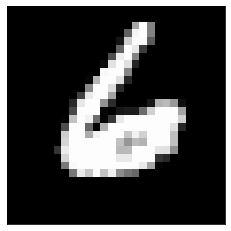

In [11]:
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.imshow(x_train[0, :, :, 0], cmap='gray');

In [12]:
print(y_train[0])

  (0, 6)	1.0


## Simple CNN

We start with a very straightforward network with a single convolutional layer.

### Required imports

In [13]:
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten
from keras.optimizers import SGD
import tensorflow as tf

Seed TensorFlow's random number generator.

In [14]:
tf.set_random_seed(40580)

### Model definition

The network has 32 filters, each 3 $\times$ 3 pixels in its convolutional layer, and a ReLU activation function. For the second, dense layer, the output of the convolutional layer is first flattened. The dense layer's activation function is SoftMax to determine the category for the image.

In [15]:
nr_filters = 32
nr_classes = 10
conv_x_size, conv_y_size = 3, 3
cnn_model = Sequential()
cnn_model.add(Conv2D(nr_filters, (conv_x_size, conv_y_size), padding='valid',
                     input_shape=shape_ord))
cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(nr_classes))
cnn_model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                216330    
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


In [16]:
cnn_hist = cnn_model.compile(loss='categorical_crossentropy',
                             optimizer=SGD(lr=0.1, decay=1.0e-6, 
                                           momentum=0.9, nesterov=True),
                             metrics=['accuracy'])

### Training

In [17]:
cnn_hist = cnn_model.fit(x_train, y_train, batch_size=32, epochs=10,
                         verbose=1, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 37s 829us/step - loss: 0.2264 - acc: 0.9338 - val_loss: 0.1326 - val_acc: 0.9611
Epoch 2/10
45000/45000 [==============================] - 34s 745us/step - loss: 0.1210 - acc: 0.9647 - val_loss: 0.1499 - val_acc: 0.9617
Epoch 3/10
45000/45000 [==============================] - 32s 713us/step - loss: 0.1041 - acc: 0.9695 - val_loss: 0.2610 - val_acc: 0.9419
Epoch 4/10
45000/45000 [==============================] - 32s 713us/step - loss: 0.0924 - acc: 0.9734 - val_loss: 0.1561 - val_acc: 0.9583
Epoch 5/10
45000/45000 [==============================] - 32s 717us/step - loss: 0.0806 - acc: 0.9768 - val_loss: 0.1923 - val_acc: 0.9525
Epoch 6/10
45000/45000 [==============================] - 31s 680us/step - loss: 0.0819 - acc: 0.9759 - val_loss: 0.1656 - val_acc: 0.9579
Epoch 7/10
45000/45000 [==============================] - 31s 695us/

In [18]:
from mnist_utils import plot_history

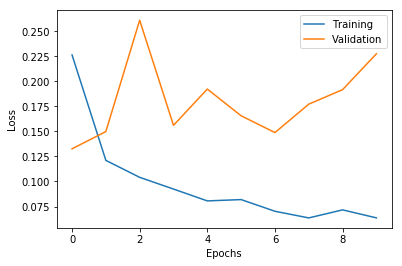

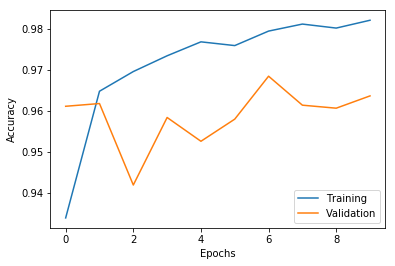

In [19]:
plot_history(cnn_hist)

In [20]:
cnn_model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 225us/step


[0.2175785810326968, 0.9654]

Although the test accuracy is quite acceptable, the training accuracy is a lot higher, so most likely there is some overfitting.

In [21]:
cnn_model.save('mnist_cnn.h5')

## More layers & dropout

This model has an additional hidden layer to improve accuracy.

In [22]:
nr_filters = 32
nr_classes = 10
conv_x_size, conv_y_size = 3, 3
cnn_do_model = Sequential()
cnn_do_model.add(Conv2D(nr_filters, (conv_x_size, conv_y_size), padding='valid',
                     input_shape=shape_ord))
cnn_do_model.add(Activation('relu'))
cnn_do_model.add(Flatten())
cnn_do_model.add(Dense(128))
cnn_do_model.add(Activation('relu'))
cnn_do_model.add(Dropout(0.1))
cnn_do_model.add(Dense(nr_classes))
cnn_do_model.add(Activation('softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
cnn_do_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2769024   
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
__________

In [24]:
cnn_do_model.compile(loss='categorical_crossentropy',
                     optimizer=SGD(),
                     metrics=['accuracy'])

In [25]:
cnn_do_hist = cnn_do_model.fit(x_train, y_train, batch_size=32, epochs=10,
                               verbose=1, validation_data=(x_val, y_val))

Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 86s 2ms/step - loss: 0.4522 - acc: 0.8761 - val_loss: 0.2440 - val_acc: 0.9279
Epoch 2/10
45000/45000 [==============================] - 82s 2ms/step - loss: 0.2087 - acc: 0.9399 - val_loss: 0.2099 - val_acc: 0.9364
Epoch 3/10
45000/45000 [==============================] - 80s 2ms/step - loss: 0.1593 - acc: 0.9539 - val_loss: 0.1390 - val_acc: 0.9589
Epoch 4/10
45000/45000 [==============================] - 76s 2ms/step - loss: 0.1355 - acc: 0.9597 - val_loss: 0.1279 - val_acc: 0.9610
Epoch 5/10
45000/45000 [==============================] - 74s 2ms/step - loss: 0.1167 - acc: 0.9648 - val_loss: 0.1101 - val_acc: 0.9665
Epoch 6/10
45000/45000 [==============================] - 73s 2ms/step - loss: 0.1048 - acc: 0.9683 - val_loss: 0.1049 - val_acc: 0.9677
Epoch 7/10
45000/45000 [==============================] - 72s 2ms/step - loss: 0.0941 - acc: 0.9719 - val_loss: 0.0916 - val_acc

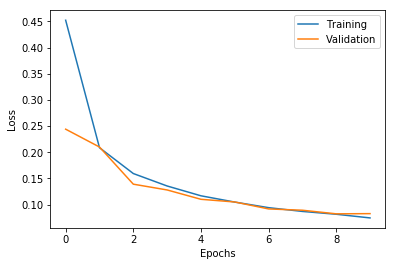

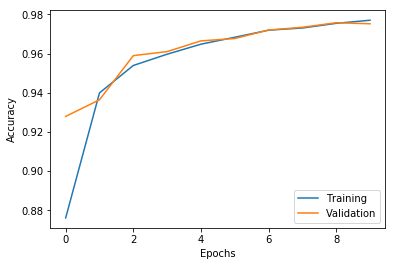

In [26]:
plot_history(cnn_do_hist)

In [27]:
cnn_do_model.evaluate(x_test, y_test)

10000/10000 [==============================] - 4s 409us/step


[0.07801886088643223, 0.9771]

Now the accuracies for training, validation and test data are more in line.

In [28]:
cnn_do_model.save('mnist_cnn_do.h5')